In [1]:
import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

import optuna


C:\Users\bhanu\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/health_misinfo_engineered_100k.csv")

# Remove leaky features
df = df.drop(columns=[
    "digit_count",
    "sentiment_polarity",
    "sentiment_subjectivity",
    "length_bucket"
])

X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [3]:
preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(stop_words="english"), "text"),
    ("num", StandardScaler(), [
        "char_length", "word_count",
        "exclaim_count", "avg_word_length"
    ])
])


In [4]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }


In [5]:
baseline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight="balanced"
    ))
])

baseline_lr.fit(X_train, y_train)
results = [evaluate(baseline_lr, "LR Baseline")]


In [6]:
param_dist_lr = {
    "preprocessor__text__max_features": [10000, 20000, 30000],
    "preprocessor__text__ngram_range": [(1,1), (1,2)],
    "model__C": np.logspace(-2, 1, 10)
}

rand_lr = RandomizedSearchCV(
    baseline_lr,
    param_distributions=param_dist_lr,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    random_state=42
)

rand_lr.fit(X_train, y_train)
results.append(evaluate(rand_lr.best_estimator_, "LR Tuned (Randomized)"))


In [7]:
svm_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearSVC(class_weight="balanced", max_iter=6000))
])

svm_grid = GridSearchCV(
    svm_pipe,
    {"model__C": [0.01, 0.1, 1, 10]},
    scoring="f1",
    cv=3,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

svm_calibrated = CalibratedClassifierCV(
    svm_grid.best_estimator_,
    method="sigmoid",
    cv=3
)

svm_calibrated.fit(X_train, y_train)
results.append(evaluate(svm_calibrated, "SVM Tuned"))


In [8]:
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_grid = GridSearchCV(
    rf_pipe,
    {
        "model__n_estimators": [100, 200],
        "model__max_depth": [10, 20, None]
    },
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
results.append(evaluate(rf_grid.best_estimator_, "Random Forest Tuned"))


In [9]:
nb_pipe = Pipeline([
    ("preprocessor", ColumnTransformer([
        ("text", TfidfVectorizer(stop_words="english"), "text")
    ])),
    ("model", MultinomialNB())
])

nb_grid = GridSearchCV(
    nb_pipe,
    {"model__alpha": [0.1, 0.5, 1.0, 2.0]},
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

nb_grid.fit(X_train, y_train)
results.append(evaluate(nb_grid.best_estimator_, "Naive Bayes Tuned"))


In [10]:
def objective(trial):
    max_features = trial.suggest_categorical("max_features", [10000, 20000, 30000])
    C = trial.suggest_float("C", 0.01, 10, log=True)

    vec = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        ngram_range=(1,2)
    )

    X_tr = vec.fit_transform(X_train["text"])
    X_te = vec.transform(X_test["text"])

    model = LogisticRegression(
        C=C,
        max_iter=3000,
        class_weight="balanced"
    )

    model.fit(X_tr, y_train)
    y_prob = model.predict_proba(X_te)[:,1]

    return roc_auc_score(y_test, y_prob)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Bayesian ROC-AUC:", study.best_value)


[I 2026-01-29 20:18:29,634] A new study created in memory with name: no-name-9d2768cb-6047-47e3-9486-c8e7551dea4e
[I 2026-01-29 20:18:30,903] Trial 0 finished with value: 1.0 and parameters: {'max_features': 20000, 'C': 9.433602923400352}. Best is trial 0 with value: 1.0.
[I 2026-01-29 20:18:32,244] Trial 1 finished with value: 1.0 and parameters: {'max_features': 20000, 'C': 0.03517036771385904}. Best is trial 0 with value: 1.0.
[I 2026-01-29 20:18:33,518] Trial 2 finished with value: 1.0 and parameters: {'max_features': 20000, 'C': 5.258201728892472}. Best is trial 0 with value: 1.0.
[I 2026-01-29 20:18:34,871] Trial 3 finished with value: 1.0 and parameters: {'max_features': 30000, 'C': 0.05330740951211294}. Best is trial 0 with value: 1.0.
[I 2026-01-29 20:18:36,206] Trial 4 finished with value: 1.0 and parameters: {'max_features': 20000, 'C': 0.032511797419344006}. Best is trial 0 with value: 1.0.
[I 2026-01-29 20:18:37,480] Trial 5 finished with value: 1.0 and parameters: {'max_f

Best Bayesian ROC-AUC: 1.0


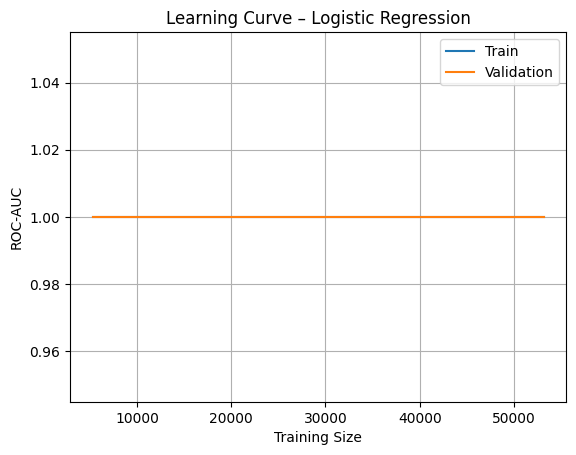

In [11]:
def plot_learning_curve(estimator, title):
    sizes, train, test = learning_curve(
        estimator,
        X_train, y_train,
        cv=3,
        scoring="roc_auc",
        n_jobs=-1
    )

    plt.plot(sizes, train.mean(axis=1), label="Train")
    plt.plot(sizes, test.mean(axis=1), label="Validation")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("ROC-AUC")
    plt.legend()
    plt.grid()
    plt.show()

plot_learning_curve(rand_lr.best_estimator_, "Learning Curve – Logistic Regression")


In [12]:
results_df = pd.DataFrame(results)
results_df


,model,accuracy,precision,recall,f1_score,roc_auc
0,LR Baseline,1.0,1.0,1.0,1.0,1.0
1,LR Tuned (Randomized),1.0,1.0,1.0,1.0,1.0
2,SVM Tuned,1.0,1.0,1.0,1.0,1.0
3,Random Forest Tuned,1.0,1.0,1.0,1.0,1.0
4,Naive Bayes Tuned,1.0,1.0,1.0,1.0,1.0


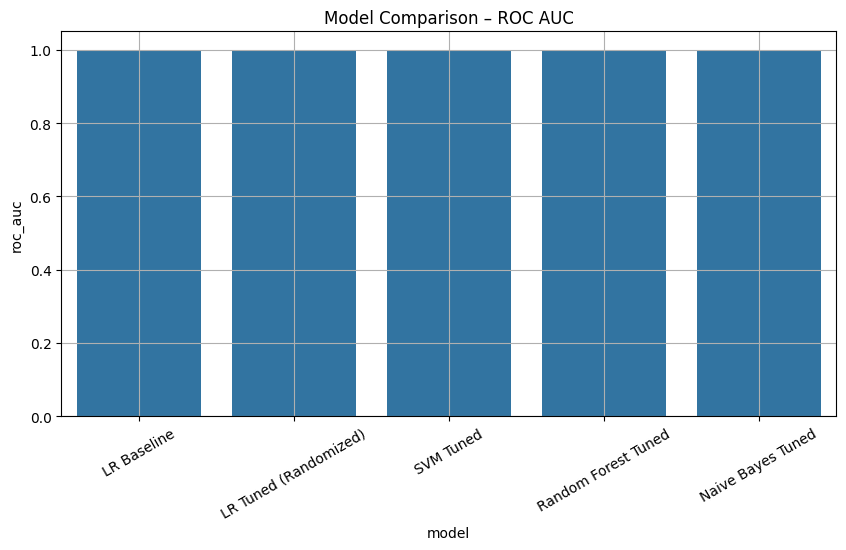

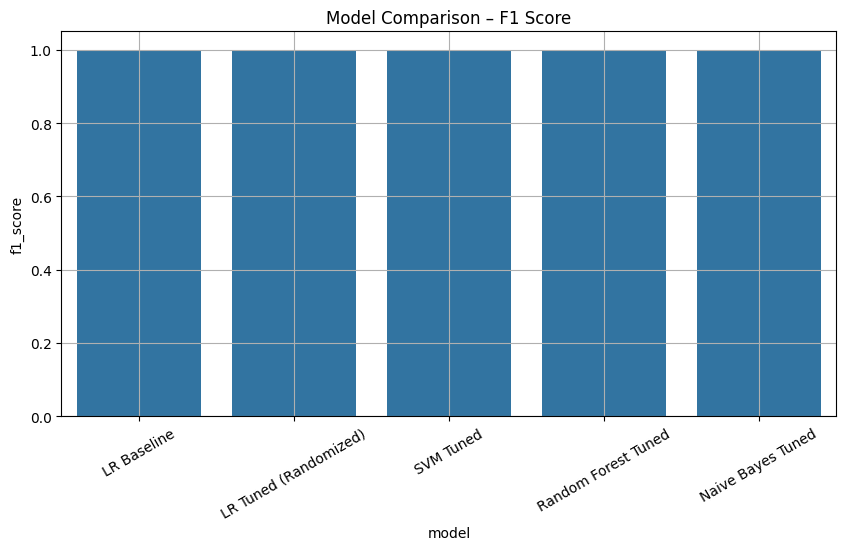

In [13]:
plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="model", y="roc_auc")
plt.title("Model Comparison – ROC AUC")
plt.xticks(rotation=30)
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=results_df, x="model", y="f1_score")
plt.title("Model Comparison – F1 Score")
plt.xticks(rotation=30)
plt.grid()
plt.show()


We use a paired t-test to statistically verify whether the performance difference between two models is significant or due to random chance.
Since both models are evaluated on the same folds, their scores are paired.

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import ttest_rel


In [15]:
best_lr = rand_lr.best_estimator_
best_nb = nb_grid.best_estimator_


In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_scores = cross_val_score(
    best_lr,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

nb_scores = cross_val_score(
    best_nb,
    X,
    y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("LR ROC-AUC scores:", lr_scores)
print("NB ROC-AUC scores:", nb_scores)


LR ROC-AUC scores: [1. 1. 1. 1. 1.]
NB ROC-AUC scores: [1. 1. 1. 1. 1.]


In [17]:
t_stat, p_value = ttest_rel(lr_scores, nb_scores)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")


T-statistic: -1.0000
P-value: 0.373901


In [18]:
alpha = 0.05

if p_value < alpha:
    print("✅ Statistically significant difference between models")
else:
    print("❌ No statistically significant difference detected")


❌ No statistically significant difference detected


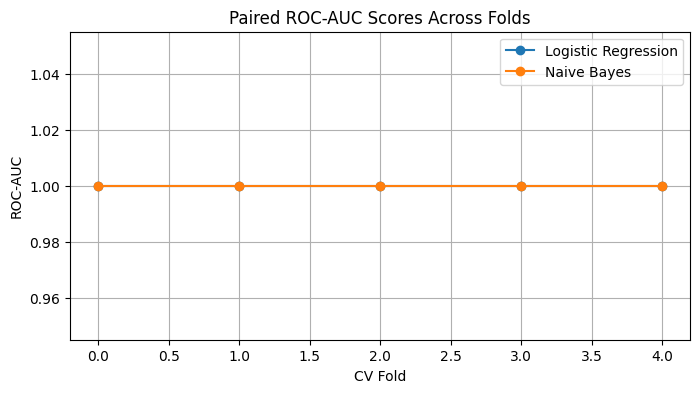

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(lr_scores, marker="o", label="Logistic Regression")
plt.plot(nb_scores, marker="o", label="Naive Bayes")
plt.xlabel("CV Fold")
plt.ylabel("ROC-AUC")
plt.title("Paired ROC-AUC Scores Across Folds")
plt.legend()
plt.grid()
plt.show()


In [20]:
stat_summary = pd.DataFrame({
    "Model A": ["Logistic Regression (Tuned)"],
    "Model B": ["Naive Bayes (Tuned)"],
    "Mean ROC-AUC A": [lr_scores.mean()],
    "Mean ROC-AUC B": [nb_scores.mean()],
    "P-value": [p_value]
})

stat_summary


,Model A,Model B,Mean ROC-AUC A,Mean ROC-AUC B,P-value
0,Logistic Regression (Tuned),Naive Bayes (Tuned),1.0,1.0,0.373901


After hyperparameter tuning, I used a paired t-test on cross-validated ROC-AUC scores to statistically verify whether the performance difference between models was significant. This ensures the final model selection is not due to random variation.”

1️⃣ TF-IDF Vectorizer

max_features

stop_words

ngram_range

min_df

max_df

2️⃣ Logistic Regression



max_iter

class_weight

penalty

solver

3️⃣ Linear SVM


class_weight

max_iter

4️⃣ Naive Bayes (MultinomialNB)

alpha

5️⃣ Random Forest

n_estimators

max_depth

min_samples_split

min_samples_leaf

max_features

random_state

6️⃣ Calibration (Probability Calibration)

method

cv

7️⃣ Train–Test Split

test_size

stratify

random_state

8️⃣ Hyperparameter Tuning

cv

scoring

n_iter

param_grid

param_distributions

9️⃣ Threshold / Business Logic

decision_threshold

false_negative_cost

false_positive_cost

10️⃣ Learning Curves

train_sizes

cv

scoring

11️⃣ Bayesian Optimization

n_trials

suggest_float

suggest_categorical